In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

import time
import matplotlib.pyplot as plt

import SelfAI

### Reading the Data

In [2]:
df = pd.read_csv('Weather Sats.csv')
df.head()

,Date,Hour,Temperature,Wet Temperature,Dew point Temperature,Relative humidity,wind speed,Wind Direction (Degrees)
0,01/04/2010,2:00,13.6,10.8,8,69,2.5,110
1,01/04/2010,5:00,12.2,10.1,7.9,75,3,110
2,01/04/2010,8:00,16.5,12.9,9.4,63,1,320
3,01/04/2010,11:00,19.7,15.4,11.9,61,3.5,240
4,01/04/2010,14:00,20.9,16.1,12.3,58,3,310


### Adding a Column to Describe if it's Day or Night (AM/PM)

In [3]:
# removing the ':00' prefix from the Hour 
df['Hour'] = df['Hour'].str[:-3].astype(int)

In [4]:
# adding a AM/PM column to distinguish between day and night temps
df['AMPM'] = np.where(df['Hour'] < 12, 'am', 'pm')

In [5]:
df.head()

,Date,Hour,Temperature,Wet Temperature,Dew point Temperature,Relative humidity,wind speed,Wind Direction (Degrees),AMPM
0,01/04/2010,2,13.6,10.8,8,69,2.5,110,am
1,01/04/2010,5,12.2,10.1,7.9,75,3,110,am
2,01/04/2010,8,16.5,12.9,9.4,63,1,320,am
3,01/04/2010,11,19.7,15.4,11.9,61,3.5,240,am
4,01/04/2010,14,20.9,16.1,12.3,58,3,310,pm


In [6]:
df.columns

Index(['Date', 'Hour', 'Temperature', 'Wet Temperature',
       'Dew point Temperature', 'Relative humidity', 'wind speed',
       'Wind Direction (Degrees)', 'AMPM'],
      dtype='object')

### Separate into Categorical and Contineous Variables

In [7]:
cont_col = ['Wet Temperature','Dew point Temperature','Relative humidity','wind speed','Wind Direction (Degrees)']
cat_col = ['Hour','AMPM']
label_col = ['Temperature']

In [8]:
# removing all rows have missing values to avoid misleading data
print(len(df))
for col in cont_col:
    df = df[~df[col].str.contains('-')]
print(len(df))


28714
27455


In [9]:
df = SelfAI.define_type(df, cat_col, 'category')
df = SelfAI.define_type(df, cont_col, 'float')
df = SelfAI.define_type(df, label_col, 'float')

### Calculating the mean temperature for each hour of the day to fill the missing temperature columns

### Stacking categorical, contineous and labels and turning them into tensors

In [10]:
df.dtypes

Date                          object
Hour                        category
Temperature                  float64
Wet Temperature              float64
Dew point Temperature        float64
Relative humidity            float64
wind speed                   float64
Wind Direction (Degrees)     float64
AMPM                        category
dtype: object

In [11]:
cat_stack = SelfAI.stack_cols(df, cat_col, torch.int64, cat=1)
cont_stack = SelfAI.stack_cols(df, cont_col, torch.float)
labels = SelfAI.stack_cols(df, label_col, torch.float)

In [12]:
# torch.tensor(df[label_col].values, dtype=torch.float).reshape(-1,1)

In [13]:
cat_stack.shape

torch.Size([27455, 2])

In [14]:
cont_stack.shape

torch.Size([27455, 5])

In [15]:
labels.shape

torch.Size([27455, 1])

### Creating embedding sizes list

In [16]:
cat_szs = [len(df[col].cat.categories) for col in cat_col]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(8, 4), (2, 1)]

### Creating a Tabular Model

In [17]:
class TabularWeatherModel(nn.Module):
    
    def __init__(self, emb_szs, num_cont, out_size, layers, p=0.5):
        super().__init__()
        layerlist = []
        
        for i in layers:
            layerlist.append(nn.Linear(num_cont,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            num_cont = i
        layerlist.append(nn.Linear(layers[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        x = self.layers(x_cont)
        
        return x

In [18]:
WeatherModel = TabularWeatherModel(emb_szs, cont_stack.shape[1], 1, [200,100,50])

In [19]:
WeatherModel

TabularWeatherModel(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Define loss function and optimizer

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(WeatherModel.parameters(), lr=0.001)

In [21]:
# split the data into train and test sets
[conts_train, conts_test, cats_train, cats_test, labels_train, labels_test] = SelfAI.create_sets(cont_stack, cat_stack, labels, 20000)

In [22]:
len(conts_train)

16000

In [23]:
labels_test

tensor([[14.7000],
        [17.2000],
        [17.2000],
        ...,
        [24.0000],
        [27.1000],
        [29.2000]])

In [24]:
len(cats_train)

16000

### Train the model on the given data and print&plot results

In [25]:
import time 
start_time = time.time()

epochs = 1000
losses = []

for i in range(epochs):
    i+=1
    
    labels_pred = WeatherModel(cats_train, conts_train)
    loss = criterion(labels_pred, labels_train)
    
    losses.append(loss)
    
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3}  loss: {loss.item():10.8f}') 
print(f'\nTraining Time: {(time.time() - start_time )/60}')

epoch:   1  loss: 569.02319336
epoch: 101  loss: 5.33971453
epoch: 201  loss: 0.96311736
epoch: 301  loss: 0.24944820
epoch: 401  loss: 0.18243054
epoch: 501  loss: 0.60022104
epoch: 601  loss: 0.13457333
epoch: 701  loss: 0.53553683
epoch: 801  loss: 0.10713899
epoch: 901  loss: 0.13360465
epoch: 1000  loss: 0.09727259

Training Time: 1.6457852562268576


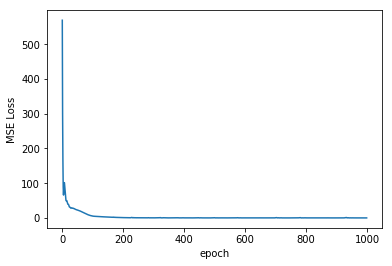

In [26]:
plt.plot(range(epochs), losses)
plt.ylabel('MSE Loss')
plt.xlabel('epoch');

### Evaluate the model on the test set

In [27]:
with torch.no_grad():
    labels_val = WeatherModel(cats_test, conts_test)
    loss = criterion(labels_test, labels_val)
print(loss)    

tensor(0.0967)


In [28]:
diffList = []
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(1200):
    diff = np.abs(labels_val[i].item()-labels_test[i].item())
    diffList.append(diff)
    print(f'{i+1:2}. {labels_val[i].item():8.4f} {labels_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  14.8051  14.7000   0.1051
 2.  17.1067  17.2000   0.0933
 3.  16.9555  17.2000   0.2445
 4.  13.4265  13.6000   0.1735
 5.  12.8139  13.1000   0.2861
 6.  15.0280  15.1000   0.0720
 7.  14.6395  14.8000   0.1605
 8.  13.9894  14.3000   0.3106
 9.  13.1672  13.4000   0.2328
10.  14.1314  14.2000   0.0686
11.  12.5354  12.7000   0.1646
12.  13.6728  13.8000   0.1272
13.  14.6522  14.7000   0.0478
14.  12.1187  12.4000   0.2813
15.  11.0134  11.2000   0.1866
16.  10.2763  10.5000   0.2237
17.  10.7683  10.9000   0.1317
18.  11.1541  11.3000   0.1459
19.  13.1650  13.3000   0.1350
20.  13.6688  14.0000   0.3312
21.  14.1561  14.3000   0.1439
22.  12.7935  12.9000   0.1065
23.  12.3862  12.5000   0.1138
24.  11.2924  11.4000   0.1076
25.  10.0732  10.1000   0.0268
26.  11.9216  11.9000   0.0216
27.  19.1889  18.6000   0.5889
28.  17.7978  17.8000   0.0022
29.  15.3159  15.0000   0.3159
30.  13.8367  13.5000   0.3367
31.  12.0687  12.2000   0.1313
32.  11.

466.  19.9368  19.8000   0.1368
467.  19.1113  19.3000   0.1887
468.  18.6334  18.4000   0.2334
469.  16.9853  16.9000   0.0853
470.  17.9205  17.1000   0.8205
471.  18.0050  18.0000   0.0050
472.  19.7584  19.6000   0.1584
473.  21.0387  20.9000   0.1387
474.  20.5081  20.2000   0.3081
475.  20.1577  20.1000   0.0577
476.  19.3629  19.2000   0.1629
477.  18.5232  18.7000   0.1768
478.  16.5885  16.7000   0.1115
479.  19.6985  19.7000   0.0015
480.  20.8777  21.1000   0.2223
481.  21.2807  21.6000   0.3193
482.  20.9572  21.1000   0.1428
483.  19.6206  19.4000   0.2206
484.  19.0845  19.0000   0.0845
485.  16.8583  16.9000   0.0417
486.  16.5351  16.4000   0.1351
487.  17.1291  16.9000   0.2291
488.  19.9617  20.3000   0.3383
489.  21.6869  21.9000   0.2131
490.  20.4148  20.2000   0.2148
491.  19.7496  19.9000   0.1504
492.  18.9115  19.3000   0.3885
493.  17.1106  17.2000   0.0894
494.  16.0088  16.1000   0.0912
495.  20.8157  20.7000   0.1157
496.  22.4671  22.9000   0.4329
497.  23

In [29]:
averageDiff = sum(diffList)/len(diffList)

In [30]:
# the average difference between predicted and actual temps in test set
averageDiff

0.2540586479504903